In [1]:
# Cell 1 – Import libraries and load the data
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Original drag accelerations (m s^-2) corresponding to each row of the error matrices.
orig_drag = np.array([
    1.55e-5, 4.35e-6, 3.68e-6, 1.02e-6, 7.79e-7,
    3.13e-7, 1.68e-7, 1.79e-8, 6.18e-9
])

# Fit-span values (number of orbits) corresponding to columns of the error matrices.
fitspans = np.arange(1, 6)

# Error matrices (RMS % error) for high-, medium- and low-noise POD models.
comm = np.array([
    [0.4, 0.2, 0.2, 0.1, 0.1],
    [2.0, 1.0, 0.7, 0.5, 0.5],
    [2.9, 1.5, 0.7, 0.9, 0.6],
    [5.0, 3.9, 2.4, 1.6, 1.5],
    [10.2, 6.3, 2.9, 2.1, 1.9],
    [16.4, 9.3, 7.1, 3.9, 3.3],
    [38.7, 22.2, 13.7, 12.5, 8.8],
    [66.9, 40.8, 26.6, 20.9, 21.2],
    [92.9, 49.4, 30.6, 22.2, 20.1]
])
med = np.array([
    [0.1, 0.1, 0.0, 0.0, 0.0],
    [0.5, 0.3, 0.2, 0.1, 0.1],
    [0.7, 0.4, 0.2, 0.2, 0.1],
    [1.3, 1.0, 0.6, 0.4, 0.3],
    [2.5, 1.6, 0.7, 0.5, 0.5],
    [4.1, 2.3, 1.8, 1.0, 0.8],
    [9.7, 5.5, 3.4, 3.1, 2.2],
    [16.7, 10.2, 6.8, 5.2, 5.3],
    [23.2, 12.3, 7.6, 5.6, 5.0]
])
low = np.array([
    [0.0, 0.0, 0.0, 0.0, 0.0],
    [0.3, 0.1, 0.1, 0.1, 0.1],
    [0.4, 0.2, 0.1, 0.1, 0.1],
    [0.6, 0.5, 0.3, 0.2, 0.2],
    [1.3, 0.8, 0.4, 0.3, 0.2],
    [2.0, 1.2, 0.9, 0.5, 0.4],
    [4.7, 3.1, 1.7, 1.7, 1.1],
    [8.1, 5.3, 3.6, 2.6, 2.6],
    [11.6, 6.2, 3.8, 2.8, 2.5]
])

In [2]:
# Cell 2 — model functions (correct floor handling; eq. 10)
E_MAX  = 97.0      # %
E_MIN  = 1.8       # %
D50    = 2.1e-7    # m s^-2
KAPPA  = 1.12

def error_surface(d, f, N=1, b=0.6):
    """
    E(d,f,N) = E_min + [(E_max - E_min)/(1+(d/d50)^kappa)] * 2^{-(f-1)} * N^{-b}
    Only the part ABOVE the floor is scaled.
    """
    L_above = (E_MAX - E_MIN) / (1.0 + (d / D50)**KAPPA)
    return E_MIN + L_above * (2.0**(-(f - 1))) * (N**(-b))

In [3]:
# Cell 3 — two-parameter fit per noise tier on the above-floor component
# Baseline (N=1) surface with correct floor handling
E_base = error_surface(orig_drag[:, None], fitspans, N=1, b=0.6)
X = (E_base - E_MIN)  # above-floor component

def fit_alpha_beta(Y, X):
    # Solve: Y - E_MIN ≈ alpha * X + beta  (least squares)
    A = np.c_[X.ravel(), np.ones(X.size)]
    y = (Y - E_MIN).ravel()
    alpha, beta = np.linalg.lstsq(A, y, rcond=None)[0]
    # enforce alpha ≥ 0 to keep shape physically sensible
    if alpha < 0:
        alpha = 0.0
        beta  = y.mean()
    return alpha, beta

def r2_score(actual, predicted):
    ss_res = np.sum((actual - predicted)**2)
    ss_tot = np.sum((actual - actual.mean())**2)
    return 1.0 - ss_res / ss_tot

# Fit and evaluate
alpha_comm, beta_comm = fit_alpha_beta(comm, X)
alpha_med,  beta_med  = fit_alpha_beta(med,  X)
alpha_low,  beta_low  = fit_alpha_beta(low,  X)

pred_comm = E_MIN + alpha_comm * X + beta_comm
pred_med  = E_MIN + alpha_med  * X + beta_med
pred_low  = E_MIN + alpha_low  * X + beta_low

print(f"alpha (high):   {alpha_comm:.3f}, beta (high):   {beta_comm:.3f}")
print(f"alpha (medium): {alpha_med:.3f}, beta (medium): {beta_med:.3f}")
print(f"alpha (low):    {alpha_low:.3f}, beta (low):    {beta_low:.3f}")

print(f"R² high:   {r2_score(comm, pred_comm):.3f}")
print(f"R² medium: {r2_score(med,  pred_med):.3f}")
print(f"R² low:    {r2_score(low,  pred_low):.3f}")

alpha (high):   0.843, beta (high):   -0.322
alpha (medium): 0.211, beta (medium): -1.433
alpha (low):    0.105, beta (low):    -1.592
R² high:   0.894
R² medium: 0.894
R² low:    0.887


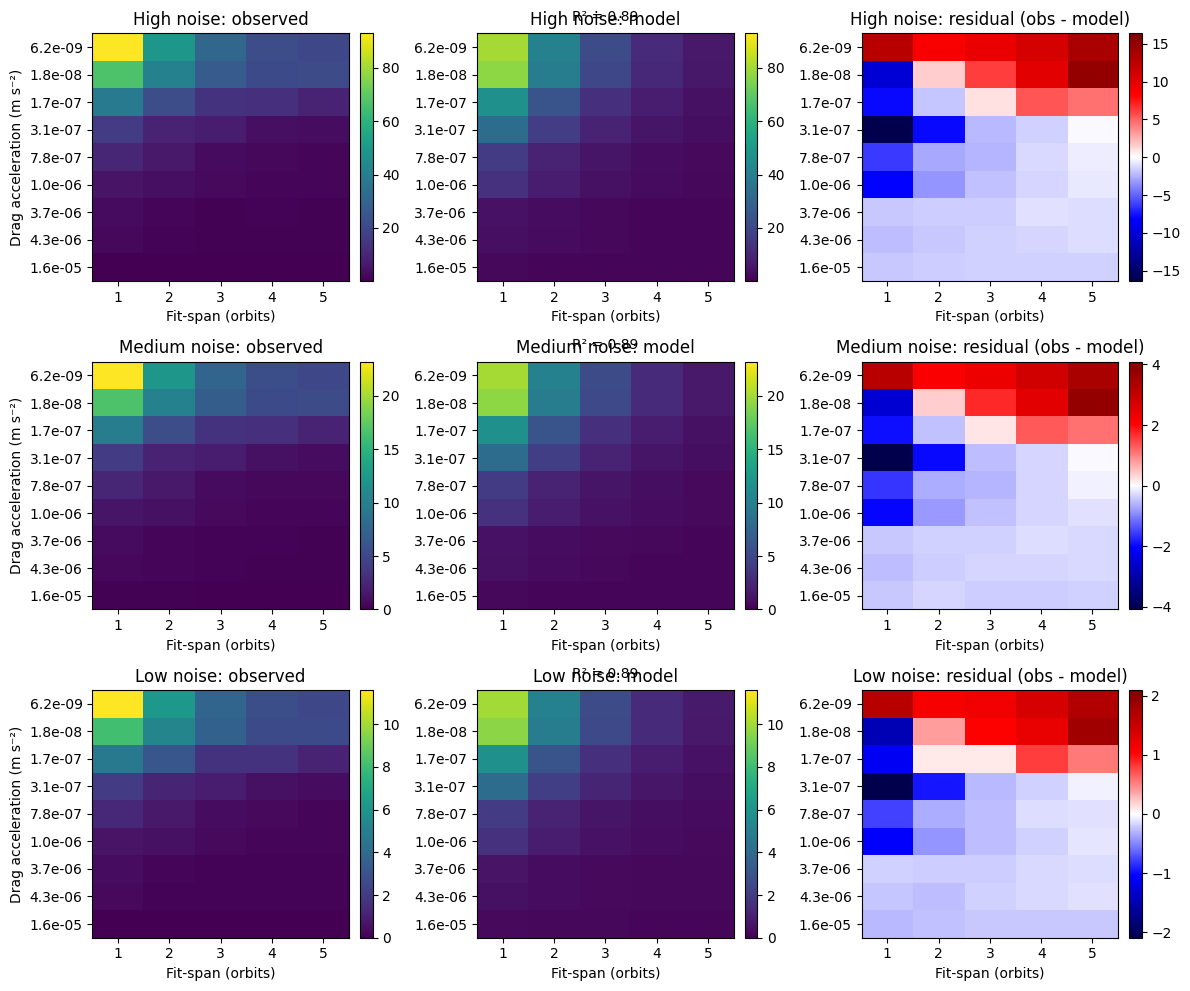

In [4]:
# Cell 4 – Plot model vs. measured matrices (uses calibrated predictions from Cell 3)
fig, axes = plt.subplots(3, 3, figsize=(12, 10))
datasets  = [comm, med, low]
preds     = [pred_comm, pred_med, pred_low]
titles    = ['High noise', 'Medium noise', 'Low noise']

for i in range(3):
    ax_obs, ax_pred, ax_diff = axes[i]
    obs  = datasets[i]
    pred = preds[i]
    diff = obs - pred

    vmin = min(obs.min(), pred.min())
    vmax = max(obs.max(), pred.max())

    im1 = ax_obs.imshow(obs, origin='lower', aspect='auto',
                        vmin=vmin, vmax=vmax, cmap='viridis')
    ax_obs.set_title(f'{titles[i]}: observed')
    ax_obs.set_xticks(np.arange(len(fitspans)))
    ax_obs.set_xticklabels(fitspans)
    ax_obs.set_yticks(np.arange(len(orig_drag)))
    ax_obs.set_yticklabels([f'{d:.1e}' for d in orig_drag])
    ax_obs.set_ylabel('Drag acceleration (m s⁻²)')
    ax_obs.set_xlabel('Fit-span (orbits)')
    fig.colorbar(im1, ax=ax_obs, fraction=0.046, pad=0.04)

    im2 = ax_pred.imshow(pred, origin='lower', aspect='auto',
                         vmin=vmin, vmax=vmax, cmap='viridis')
    ax_pred.set_title(f'{titles[i]}: model')
    ax_pred.set_xticks(np.arange(len(fitspans)))
    ax_pred.set_xticklabels(fitspans)
    ax_pred.set_yticks(np.arange(len(orig_drag)))
    ax_pred.set_yticklabels([f'{d:.1e}' for d in orig_drag])
    ax_pred.set_xlabel('Fit-span (orbits)')
    # R^2 uses r2_score defined in Cell 3
    ax_pred.text(0.5, 1.05, f'R² = {r2_score(obs, pred):.2f}',
                 transform=ax_pred.transAxes, ha='center')
    fig.colorbar(im2, ax=ax_pred, fraction=0.046, pad=0.04)

    im3 = ax_diff.imshow(diff, origin='lower', aspect='auto',
                         cmap='seismic', vmin=-np.max(np.abs(diff)), vmax=np.max(np.abs(diff)))
    ax_diff.set_title(f'{titles[i]}: residual (obs - model)')
    ax_diff.set_xticks(np.arange(len(fitspans)))
    ax_diff.set_xticklabels(fitspans)
    ax_diff.set_yticks(np.arange(len(orig_drag)))
    ax_diff.set_yticklabels([f'{d:.1e}' for d in orig_drag])
    ax_diff.set_xlabel('Fit-span (orbits)')
    fig.colorbar(im3, ax=ax_diff, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [5]:
# Cell 5 – Helper to build calibrated surfaces from the analytic model + (alpha, beta)
def calibrated_error_surface(d, f, N, b, alpha, beta):
    """
    Returns E_calib = E_min + alpha * (E_model - E_min) + beta,
    where E_model implements eq. (10) with proper floor handling.
    """
    raw = error_surface(d, f, N=N, b=b)  # from Cell 2
    return E_MIN + alpha * (raw - E_MIN) + beta

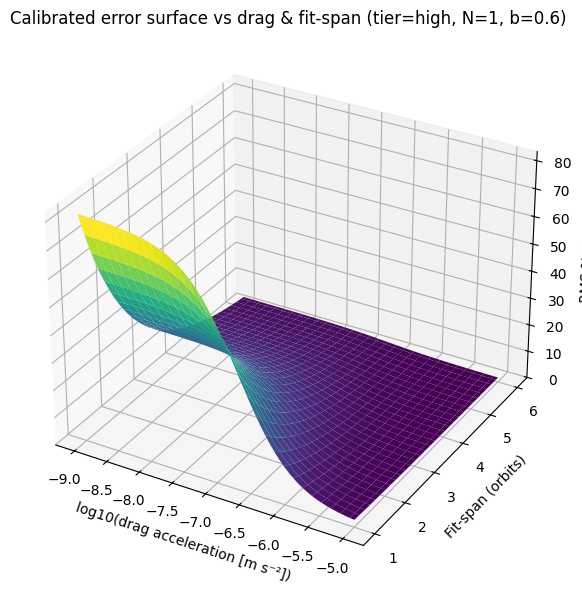

In [6]:
# Cell 6 – 3-D surface vs drag & fit-span (choose noise tier; N=1, b=0.6)
# Choose which noise tier to visualize: 'high', 'medium', or 'low'
tier = 'high'  # change to 'high' or 'medium' as needed

alpha_sel, beta_sel = {
    'high':   (alpha_comm, beta_comm),
    'medium': (alpha_med,  beta_med),
    'low':    (alpha_low,  beta_low),
}[tier]

fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection='3d')

drag_vals = np.logspace(-9, -5, 60)   # m s^-2
f_vals    = np.linspace(1, 6, 60)     # orbits
D, F      = np.meshgrid(drag_vals, f_vals)

Z = calibrated_error_surface(D, F, N=1, b=0.6, alpha=alpha_sel, beta=beta_sel)

ax.plot_surface(np.log10(D), F, Z, cmap='viridis', linewidth=0, antialiased=True)
ax.set_title(f'Calibrated error surface vs drag & fit-span (tier={tier}, N=1, b=0.6)')
ax.set_xlabel('log10(drag acceleration [m s⁻²])')
ax.set_ylabel('Fit-span (orbits)')
ax.set_zlabel('RMS % error')
plt.tight_layout()
plt.show()

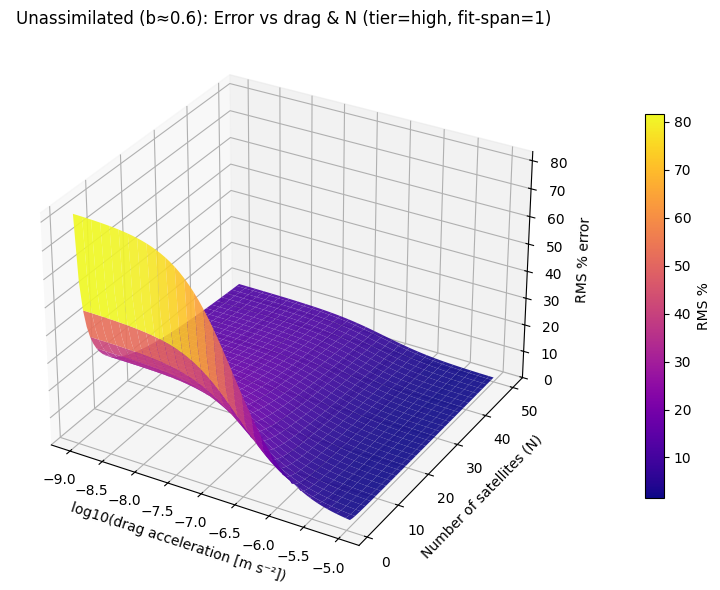

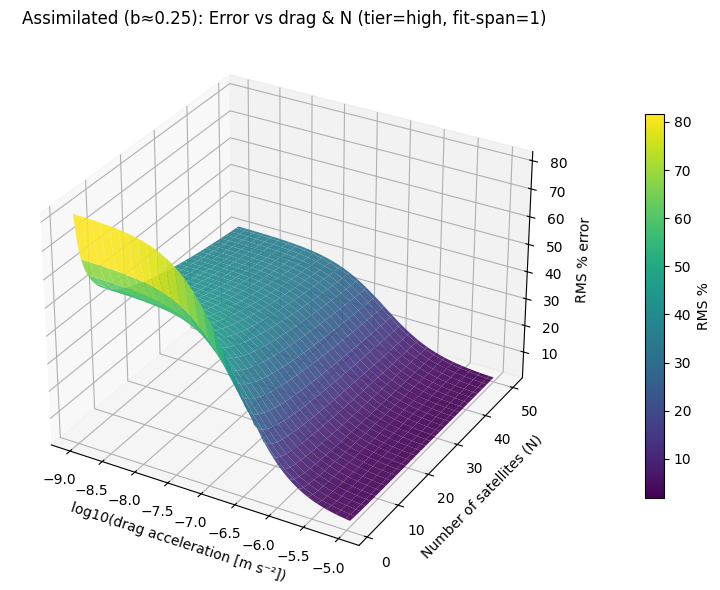

In [7]:
# Cell 7 (Matplotlib) – Separate 3D surfaces: one unassimilated (b=0.6), one assimilated (b=0.25)
# Requires: calibrated_error_surface, tier, alpha_sel, beta_sel from previous cells.

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (ensures 3D projection is registered)
from matplotlib.colors import Normalize
import matplotlib.cm as cm

# Fixed fit-span for this visualization
f_fixed = 1  # change if desired

# Grid
drag_vals2 = np.logspace(-9, -5, 60)   # m s^-2
N_vals     = np.linspace(1, 50, 60)    # satellites
D2, N2     = np.meshgrid(drag_vals2, N_vals)
X_log      = np.log10(drag_vals2)      # x-axis values
X2         = np.tile(X_log, (N_vals.size, 1))  # make 2D for plot_surface

# Calibrated surfaces
Z_un  = calibrated_error_surface(D2, f_fixed, N2, b=0.60, alpha=alpha_sel, beta=beta_sel)
Z_ass = calibrated_error_surface(D2, f_fixed, N2, b=0.25, alpha=alpha_sel, beta=beta_sel)

# --- Figure 1: Unassimilated ---
fig_un = plt.figure(figsize=(9, 6))
ax_un  = fig_un.add_subplot(111, projection='3d')
surf_un = ax_un.plot_surface(X2, N2, Z_un, cmap='plasma', linewidth=0, antialiased=True, alpha=0.9)

ax_un.set_title(f'Unassimilated (b≈0.6): Error vs drag & N (tier={tier}, fit-span={f_fixed})')
ax_un.set_xlabel('log10(drag acceleration [m s⁻²])')
ax_un.set_ylabel('Number of satellites (N)')
ax_un.set_zlabel('RMS % error')

# Proper colorbar for 3D surface
norm_un = Normalize(vmin=Z_un.min(), vmax=Z_un.max())
mappable_un = cm.ScalarMappable(norm=norm_un, cmap='plasma')
mappable_un.set_array([])
cbar_un = fig_un.colorbar(mappable_un, ax=ax_un, shrink=0.7, pad=0.1)
cbar_un.set_label('RMS %')

plt.tight_layout()
plt.show()

# --- Figure 2: Assimilated ---
fig_ass = plt.figure(figsize=(9, 6))
ax_ass  = fig_ass.add_subplot(111, projection='3d')
surf_ass = ax_ass.plot_surface(X2, N2, Z_ass, cmap='viridis', linewidth=0, antialiased=True, alpha=0.9)

ax_ass.set_title(f'Assimilated (b≈0.25): Error vs drag & N (tier={tier}, fit-span={f_fixed})')
ax_ass.set_xlabel('log10(drag acceleration [m s⁻²])')
ax_ass.set_ylabel('Number of satellites (N)')
ax_ass.set_zlabel('RMS % error')

norm_ass = Normalize(vmin=Z_ass.min(), vmax=Z_ass.max())
mappable_ass = cm.ScalarMappable(norm=norm_ass, cmap='viridis')
mappable_ass.set_array([])
cbar_ass = fig_ass.colorbar(mappable_ass, ax=ax_ass, shrink=0.7, pad=0.1)
cbar_ass.set_label('RMS %')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3022613647.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


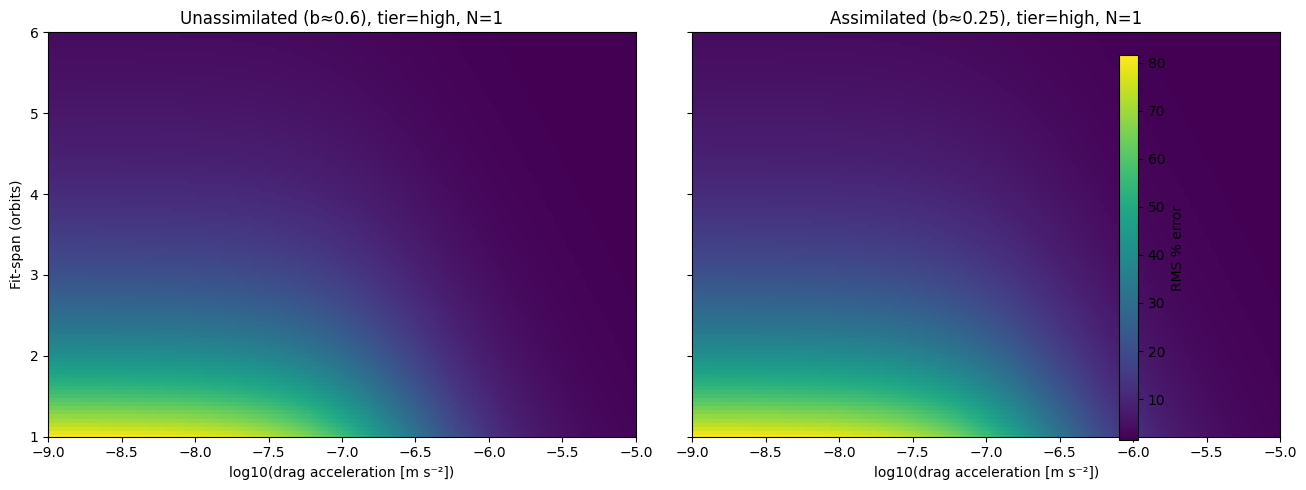

In [8]:
# Cell 7 (Matplotlib, static) – Heatmaps with Fit-span on Y, log10(drag) on X, colour = RMS % error
# Shows two static panels: Unassimilated (b≈0.6) and Assimilated (b≈0.25)
# Requires: calibrated_error_surface, tier, alpha_sel, beta_sel from previous cells.

import numpy as np
import matplotlib.pyplot as plt

# Choose number of satellites to visualize (scalar N across the heatmap)
N_sel = 1  # change as desired

# Build grid over drag and fit-span
drag_vals = np.logspace(-9, -5, 200)   # m s^-2
f_vals    = np.linspace(1, 6, 101)     # orbits
D, F      = np.meshgrid(drag_vals, f_vals)
X_log     = np.log10(drag_vals)        # x-axis (linear in log10)

# Compute calibrated error fields for both cases
Z_un  = calibrated_error_surface(D, F, N_sel, b=0.60, alpha=alpha_sel, beta=beta_sel)
Z_ass = calibrated_error_surface(D, F, N_sel, b=0.25, alpha=alpha_sel, beta=beta_sel)

# Common color limits for fair comparison
vmin = min(Z_un.min(), Z_ass.min())
vmax = max(Z_un.max(), Z_ass.max())

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

# Unassimilated heatmap
im1 = ax1.pcolormesh(np.tile(X_log, (F.shape[0], 1)), F, Z_un,
                     shading='auto', cmap='viridis', vmin=vmin, vmax=vmax)
ax1.set_title(f'Unassimilated (b≈0.6), tier={tier}, N={N_sel}')
ax1.set_xlabel('log10(drag acceleration [m s⁻²])')
ax1.set_ylabel('Fit-span (orbits)')
ax1.set_xlim(X_log.min(), X_log.max())
ax1.set_ylim(f_vals.min(), f_vals.max())

# Assimilated heatmap
im2 = ax2.pcolormesh(np.tile(X_log, (F.shape[0], 1)), F, Z_ass,
                     shading='auto', cmap='viridis', vmin=vmin, vmax=vmax)
ax2.set_title(f'Assimilated (b≈0.25), tier={tier}, N={N_sel}')
ax2.set_xlabel('log10(drag acceleration [m s⁻²])')
ax2.set_xlim(X_log.min(), X_log.max())
ax2.set_ylim(f_vals.min(), f_vals.max())

# Single shared colorbar
cbar = fig.colorbar(im2, ax=[ax1, ax2], fraction=0.046, pad=0.04)
cbar.set_label('RMS % error')

plt.tight_layout()
plt.show()

In [9]:
# Cell — Requirements for <5% RMS error at 450/550/650 km (unassimilated) using MSIS if available
# This version attempts to use pymsis for density; if pymsis is not installed in your environment,
# it falls back to a simple exponential model (which approximates MSIS reasonably within an order).
# Replace the fallback densities with real MSIS outputs if available.

import numpy as np
import pandas as pd
from datetime import datetime

# --- Model constants (taken from earlier cells) ---
E_MAX  = globals().get('E_MAX', 97.0)
E_MIN  = globals().get('E_MIN', 1.8)
D50    = globals().get('D50', 2.1e-7)
KAPPA  = globals().get('KAPPA', 1.12)
B_UNASSIM = 0.6  # unassimilated exponent
alpha_comm = globals().get('alpha_comm', 1.0); beta_comm = globals().get('beta_comm', 0.0)
alpha_med  = globals().get('alpha_med',  1.0); beta_med  = globals().get('beta_med',  0.0)
alpha_low  = globals().get('alpha_low',  1.0); beta_low  = globals().get('beta_low',  0.0)
tier_calib = {'high': (alpha_comm, beta_comm), 'medium': (alpha_med, beta_med), 'low': (alpha_low, beta_low)}

CD   = 2.2
RE   = 6371e3             # Earth radius (m)
MU   = 3.986004418e14     # m^3/s^2

def orbital_speed(alt_km):
    r = RE + alt_km*1e3
    return np.sqrt(MU / r)

def drag_accel(rho, amr, v, cd=CD):
    return 0.5 * cd * amr * rho * v**2

def error_surface(d, f, N=1, b=B_UNASSIM):
    L_above = (E_MAX - E_MIN) / (1.0 + (d / D50)**KAPPA)
    return E_MIN + L_above * (2.0**(-(f - 1))) * (N**(-b))

def calibrated_error_surface(d, f, N, b, alpha, beta):
    raw = error_surface(d, f, N, b=b)
    return E_MIN + alpha*(raw - E_MIN) + beta

# --- Density function: try MSIS, else fallback exponential ---
def get_density_kg_m3(alt_km, solar_level):
    """
    Return mass density (kg/m^3) for a given altitude (km) and solar activity.
    If pymsis is installed, uses MSIS; otherwise uses a simple exponential fallback.
    """
    try:
        import pymsis
        import xarray as xr
        f107_map = {'low': 70.0, 'medium': 110.0, 'high': 160.0}
        ap_map   = {'low': 4.0,  'medium': 12.0,  'high': 27.0}
        f107  = float(f107_map[solar_level])
        ap    = float(ap_map[solar_level])
        t     = datetime(2024, 3, 21, 12)
        alt   = np.atleast_1d(float(alt_km))
        lat   = np.array([0.0])
        lon   = np.array([0.0])
        ds    = pymsis.run(t, alt, lat, lon, f107, f107, ap)
        # Attempt to extract total mass density
        if isinstance(ds, xr.Dataset):
            for k in ds.data_vars:
                if k.lower().replace(' ','_') in ('total_mass_density','mass_density','rho'):
                    return float(ds[k].squeeze().values)
            # Sum species densities if needed
            species = [k for k in ds.data_vars if k.lower().endswith('_density') and 'total' not in k.lower()]
            if species:
                rho = None
                for k in species:
                    arr = ds[k].squeeze().values
                    rho = arr if rho is None else (rho + arr)
                return float(np.asarray(rho))
            # Fallback to first variable
            return float(ds[list(ds.data_vars)[0]].squeeze().values)
        elif isinstance(ds, xr.DataArray):
            return float(ds.squeeze().values)
        elif isinstance(ds, dict):
            for k in ('Total mass density','total_mass_density','mass_density','rho','Rho','Total_density'):
                if k in ds:
                    return float(np.asarray(ds[k]).squeeze())
            # Sum species densities if needed
            species = [k for k in ds if k.lower().endswith('_density') and 'total' not in k.lower()]
            if species:
                return float(np.sum([np.asarray(ds[k]).squeeze() for k in species]))
            raise KeyError("MSIS output lacks a recognizable mass-density variable.")
        else:
            return float(np.asarray(ds).squeeze())
    except Exception:
        # Fallback simple exponential model tuned to approximate MSIS
        # Base densities (kg/m^3) at 400 km for solar states, scale height ~50 km
        base_rho = {'low': 4e-12, 'medium': 9e-12, 'high': 2e-11}
        H = 50.0  # scale height in km
        rho0 = base_rho[solar_level]
        return rho0 * np.exp(-(alt_km - 400.0)/H)

# --- Configuration ---
alts_km   = [450, 550, 650]
cases_amr = {'Starlink (open-book)':0.005, 'Starlink (shark-fin)':0.05, 'Spire':0.02}
solar_set  = ['low','medium','high']
noise_tier = 'high'  # choose high/medium/low
alpha_sel, beta_sel = tier_calib[noise_tier]

TARGET_ERR = 25.0  # %
MAX_F, MAX_N = 2, 500

def find_min_pair(d_val, b, alpha, beta, target=TARGET_ERR, f_max=MAX_F, n_max=MAX_N):
    """
    Find the minimal pair (fit-span, N) to achieve error ≤ target.
    Minimizes f*N; ties broken by lower N then lower f.
    """
    best = None
    for f in range(1, f_max+1):
        for N in range(1, n_max+1):
            e = calibrated_error_surface(d_val, f, N, b=b, alpha=alpha, beta=beta)
            if e <= target:
                budget = f*N
                if best is None or budget < best[0] or (budget == best[0] and (N < best[2] or (N == best[2] and f < best[1]))):
                    best = (budget, f, N, e)
                break  # minimal N found for this f
    return (None, None, None, None) if best is None else best

# --- Compute requirements ---
rows = []
for solar in solar_set:
    for alt in alts_km:
        rho = get_density_kg_m3(alt, solar)
        v   = orbital_speed(alt)
        for name, amr in cases_amr.items():
            dval = drag_accel(rho, amr, v)
            budget, f_req, n_req, e_ach = find_min_pair(dval, B_UNASSIM, alpha_sel, beta_sel)
            rows.append({
                'solar': solar,
                'alt_km': alt,
                'case': name,
                'AMR_m2_per_kg': amr,
                'noise_tier': noise_tier,
                'density_kg_m3': rho,
                'drag_m_s2': dval,
                'fit_span_needed': f_req,
                'satellites_needed': n_req,
                'result_error_%': e_ach,
                'budget_f_times_N': budget
            })

req5_df = pd.DataFrame(rows).sort_values(['solar','alt_km','case'])
req5_df

solar  alt_km                  case  AMR_m2_per_kg noise_tier  \
20    high     450                 Spire          0.020       high   
18    high     450  Starlink (open-book)          0.005       high   
19    high     450  Starlink (shark-fin)          0.050       high   
23    high     550                 Spire          0.020       high   
21    high     550  Starlink (open-book)          0.005       high   
22    high     550  Starlink (shark-fin)          0.050       high   
26    high     650                 Spire          0.020       high   
24    high     650  Starlink (open-book)          0.005       high   
25    high     650  Starlink (shark-fin)          0.050       high   
2      low     450                 Spire          0.020       high   
0      low     450  Starlink (open-book)          0.005       high   
1      low     450  Starlink (shark-fin)          0.050       high   
5      low     550                 Spire          0.020       high   
3      low     550  Starlink (open-book)          0.005       high   
4      low     550  Starlink (shark-fin)          0.050       high   
8      low     650                 Spire          0.020       high   
6      low     650  Starlink (open-book)          0.005       high   
7      low     650  Starlink (shark-fin)          0.050       high   
11  medium     450                 Spire          0.020       high   
9   medium     450  Starlink (open-book)          0.005       high   
10  medium     450  Starlink (shark-fin)          0.050       high   
14  medium     550                 Spire          0.020       high   
12  medium     550  Starlink (open-book)          0.005       high   
13  medium     550  Starlink (shark-fin)          0.050       high   
17  medium     650                 Spire          0.020       high   
15  medium     650  Starlink (open-book)          0.005       high   
16  medium     650  Starlink (shark-fin)          0.050       high   

    density_kg_m3     drag_m_s2  fit_span_needed  satellites_needed  \
20   7.357589e-12  9.459059e-06                1                  1   
18   7.357589e-12  2.364765e-06                1                  1   
19   7.357589e-12  2.364765e-05                1                  1   
23   9.957414e-13  1.261648e-06                1                  1   
21   9.957414e-13  3.154120e-07                2                  1   
22   9.957414e-13  3.154120e-06                1                  1   
26   1.347589e-13  1.683135e-07                2                  1   
24   1.347589e-13  4.207839e-08                2                  2   
25   1.347589e-13  4.207839e-07                2                  1   
2    1.471518e-12  1.891812e-06                1                  1   
0    1.471518e-12  4.729529e-07                1                  1   
1    1.471518e-12  4.729529e-06                1                  1   
5    1.991483e-13  2.523296e-07                2                  1   
3    1.991483e-13  6.308239e-08                2                  2   
4    1.991483e-13  6.308239e-07                1                  1   
8    2.695179e-14  3.366271e-08                2                  2   
6    2.695179e-14  8.415677e-09                2                  3   
7    2.695179e-14  8.415677e-08                2                  2   
11   3.310915e-12  4.256576e-06                1                  1   
9    3.310915e-12  1.064144e-06                1                  1   
10   3.310915e-12  1.064144e-05                1                  1   
14   4.480836e-13  5.677415e-07                1                  1   
12   4.480836e-13  1.419354e-07                2                  2   
13   4.480836e-13  1.419354e-06                1                  1   
17   6.064152e-14  7.574110e-08                2                  2   
15   6.064152e-14  1.893527e-08                2                  3   
16   6.064152e-14  1.893527e-07                2                  1   

    result_error_%  budget_f_times_N  
20        2.5907

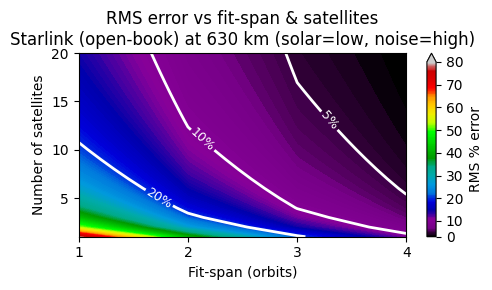

In [26]:
# Cell – Contour plot with smooth colours and colour bar ticks every 10 %

import numpy as np
import matplotlib.pyplot as plt

# Choose scenario
alt_sel   = 630        # km
case_sel  = 'Starlink (open-book)'
solar_sel = 'low'   # low/medium/high
noise_sel = 'high'     # POD noise tier
alpha_sel, beta_sel = tier_calib[noise_sel]

# Compute drag acceleration
rho_sel = get_density_kg_m3(alt_sel, solar_sel)
v_sel   = orbital_speed(alt_sel)
amr_sel = req5_df[req5_df['case'] == case_sel]['AMR_m2_per_kg'].iloc[0]
d_sel   = drag_accel(rho_sel, amr_sel, v_sel)

# Grid of fit-span and N
f_vals = np.arange(1, 5)      # integer fit-spans (1–5)
N_vals = np.arange(1, 21)     # satellites (1–19)
F_grid, N_grid = np.meshgrid(f_vals, N_vals)

# Error surface (unassimilated)
E_grid = calibrated_error_surface(d_sel, F_grid, N_grid, B_UNASSIM, alpha_sel, beta_sel)

# Define a smooth colour scale up to 80 %, with extension above if needed
max_display = 80.0
levels_fill = np.linspace(E_grid.min(), max_display, 200)  # many levels for smooth gradient
levels_lines = [5.0, 10.0, 20.0]

# Plot
fig, ax = plt.subplots(figsize=(5, 3))
cs = ax.contourf(F_grid, N_grid, E_grid, levels=levels_fill,
                 cmap='nipy_spectral', extend='max')
cs2 = ax.contour(F_grid, N_grid, E_grid, levels=levels_lines,
                 colors='white', linewidths=2)
ax.clabel(cs2, fmt={level: f'{int(level)}%' for level in levels_lines},
          inline=True, fontsize=9)

ax.set_title(f'RMS error vs fit-span & satellites\n{case_sel} at {alt_sel} km (solar={solar_sel}, noise={noise_sel})')
ax.set_xlabel('Fit-span (orbits)')
ax.set_ylabel('Number of satellites')
ax.set_xticks(f_vals)  # integer ticks on x-axis

# Colour bar with tick labels every 10 %
cbar = plt.colorbar(cs, ax=ax)
cbar.set_label('RMS % error')
cbar.set_ticks(np.arange(0, max_display+1, 10))

plt.tight_layout()
plt.savefig('error_surface_vs_fit_span_and_satellites.png', dpi=300)
plt.show()

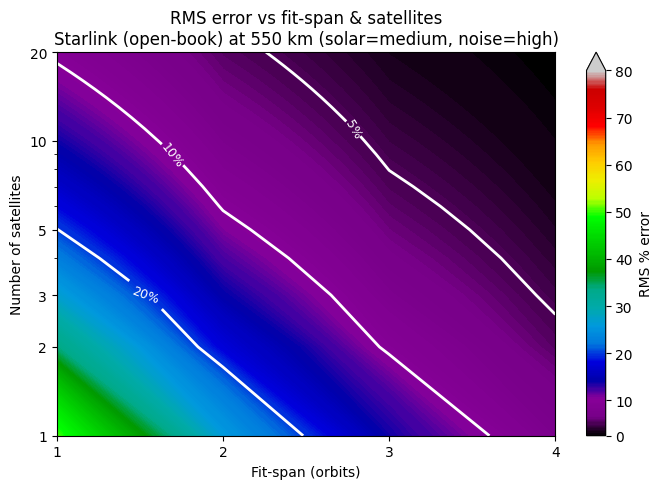

In [11]:
# Cell – Contour plot with smooth colours, colour bar ticks every 10 %, and LOG-scaled N-axis

import numpy as np
import matplotlib.pyplot as plt

# Choose scenario
alt_sel   = 550        # km
case_sel  = 'Starlink (open-book)'
solar_sel = 'medium'      # low/medium/high
noise_sel = 'high'     # POD noise tier
alpha_sel, beta_sel = tier_calib[noise_sel]

# Drag acceleration
rho_sel = get_density_kg_m3(alt_sel, solar_sel)
v_sel   = orbital_speed(alt_sel)
amr_sel = req5_df[req5_df['case'] == case_sel]['AMR_m2_per_kg'].iloc[0]
d_sel   = drag_accel(rho_sel, amr_sel, v_sel)

# Grid
f_vals = np.arange(1, 5)      # fit-spans 1–4 (integers)
N_vals = np.arange(1, 21)     # satellites 1–20 (integers)
F_grid, N_grid = np.meshgrid(f_vals, N_vals)

# Error surface
E_grid = calibrated_error_surface(d_sel, F_grid, N_grid, B_UNASSIM, alpha_sel, beta_sel)

# Colour scale and contour lines
max_display  = 80.0
levels_fill  = np.linspace(E_grid.min(), max_display, 300)  # smooth gradient
levels_lines = [5.0, 10.0, 20.0]

# Plot
fig, ax = plt.subplots(figsize=(7, 5))
cs  = ax.contourf(F_grid, N_grid, E_grid, levels=levels_fill,
                  cmap='nipy_spectral', extend='max')
cs2 = ax.contour(F_grid, N_grid, E_grid, levels=levels_lines,
                 colors='white', linewidths=2)
ax.clabel(cs2, fmt={level: f'{int(level)}%' for level in levels_lines},
          inline=True, fontsize=9)

ax.set_title(f'RMS error vs fit-span & satellites\n{case_sel} at {alt_sel} km (solar={solar_sel}, noise={noise_sel})')
ax.set_xlabel('Fit-span (orbits)')
ax.set_ylabel('Number of satellites')

# Integer ticks for fit-span
ax.set_xticks(f_vals)

# LOG-scale for N with integer-friendly ticks
ax.set_yscale('log')
yticks = [1, 2, 3, 5, 10, 20]
ax.set_yticks(yticks)
ax.set_yticklabels([str(y) for y in yticks])

# Colour bar with tick labels every 10 %
cbar = plt.colorbar(cs, ax=ax)
cbar.set_label('RMS % error')
cbar.set_ticks(np.arange(0, max_display+1, 10))

plt.tight_layout()
plt.show()

/tmp/ipython-input-2743578310.py:81: UserWarning: You passed in an explicit save_count=21 which is being ignored in favor of len(frames)=21.
  anim = FuncAnimation(


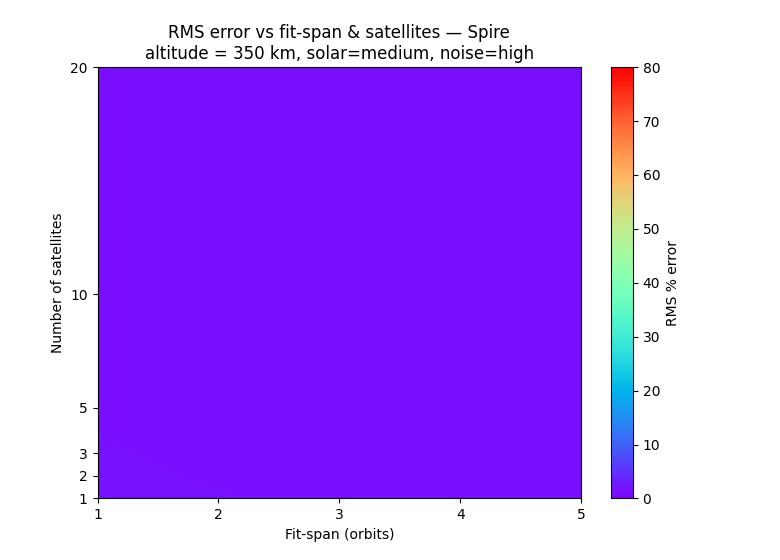

Saved animation to error_surface_vs_altitude.gif


In [12]:
# Cell – Animate the contour plot across altitude (350–850 km) and save as GIF (robust)
# Fixed colour scale (0–80%), log-scaled N-axis, and 5/10/20% contour lines.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import Normalize
from IPython.display import Image, display

# --- Scenario ---
case_sel   = 'Spire'   # 'Starlink (shark-fin)' or 'Spire'
solar_sel  = 'medium'                    # 'low' / 'medium' / 'high'
noise_sel  = 'high'                   # POD noise tier
alpha_sel, beta_sel = tier_calib[noise_sel]

# AMR for the chosen case (fallback if not in req5_df)
amr_lookup = {'Starlink (open-book)': 0.005, 'Starlink (shark-fin)': 0.05, 'Spire': 0.02}
try:
    amr_sel = req5_df.loc[req5_df['case'] == case_sel, 'AMR_m2_per_kg'].iloc[0]
except Exception:
    amr_sel = amr_lookup[case_sel]

# Altitude sweep and grids
alts_km = np.arange(350, 851, 25)    # 350→850 km
f_vals  = np.arange(1, 6)            # fit-spans 1–5
N_vals  = np.arange(1, 21)           # satellites 1–20
F_grid, N_grid = np.meshgrid(f_vals, N_vals)

# Colour mapping and contour lines (fixed across frames)
max_display  = 80.0
levels_fill  = np.linspace(0.0, max_display, 300)   # smooth gradient
levels_lines = [5.0, 10.0, 20.0, 50.0]
norm = Normalize(vmin=0.0, vmax=max_display)
# cmap = plt.cm.nipy_spectral
cmap = plt.cm.rainbow

def compute_E_grid(alt_km):
    rho = get_density_kg_m3(alt_km, solar_sel)
    v   = orbital_speed(alt_km)
    d   = drag_accel(rho, amr_sel, v)
    return calibrated_error_surface(d, F_grid, N_grid, B_UNASSIM, alpha_sel, beta_sel)

# Figure + a static colorbar driven by a ScalarMappable
fig, ax = plt.subplots(figsize=(7.8, 5.6))
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, ticks=np.arange(0, max_display+1, 10))
cbar.set_label('RMS % error')

def style_axes():
    ax.set_xlabel('Fit-span (orbits)')
    ax.set_ylabel('Number of satellites')
    ax.set_xticks(f_vals)
    # ax.set_yscale('log')
    ax.set_yticks([1, 2, 3, 5, 10, 20])
    ax.set_yticklabels(['1', '2', '3', '5', '10', '20'])

# Init function draws the first frame; return [] is fine with blit=False
def init():
    ax.clear()
    E0 = compute_E_grid(alts_km[0])
    ax.contourf(F_grid, N_grid, E0, levels=levels_fill, norm=norm, cmap=cmap, extend='max')
    lines = ax.contour(F_grid, N_grid, E0, levels=levels_lines, colors='white', linewidths=2)
    ax.clabel(lines, fmt={lv: f'{int(lv)}%' for lv in levels_lines}, inline=True, fontsize=9)
    style_axes()
    ax.set_title(f'RMS error vs fit-span & satellites — {case_sel}\n'
                 f'altitude = {int(alts_km[0])} km, solar={solar_sel}, noise={noise_sel}')
    return []

# Update function: clear and redraw (no artist juggling)
def update(alt):
    ax.clear()
    E = compute_E_grid(alt)
    ax.contourf(F_grid, N_grid, E, levels=levels_fill, norm=norm, cmap=cmap, extend='max')
    lines = ax.contour(F_grid, N_grid, E, levels=levels_lines, colors='white', linewidths=2)
    ax.clabel(lines, fmt={lv: f'{int(lv)}%' for lv in levels_lines}, inline=True, fontsize=9)
    style_axes()
    ax.set_title(f'RMS error vs fit-span & satellites — {case_sel}\n'
                 f'altitude = {int(alt)} km, solar={solar_sel}, noise={noise_sel}')
    return []

anim = FuncAnimation(
    fig, update, frames=alts_km, init_func=init,
    interval=400, blit=False, save_count=len(alts_km)
)

gif_path = 'error_surface_vs_altitude.gif'
anim.save(gif_path, writer=PillowWriter(fps=6))
plt.close(fig)

display(Image(filename=gif_path))
print(f"Saved animation to {gif_path}")

/tmp/ipython-input-981744354.py:139: UserWarning: You passed in an explicit save_count=81 which is being ignored in favor of len(frames)=81.
  anim = FuncAnimation(


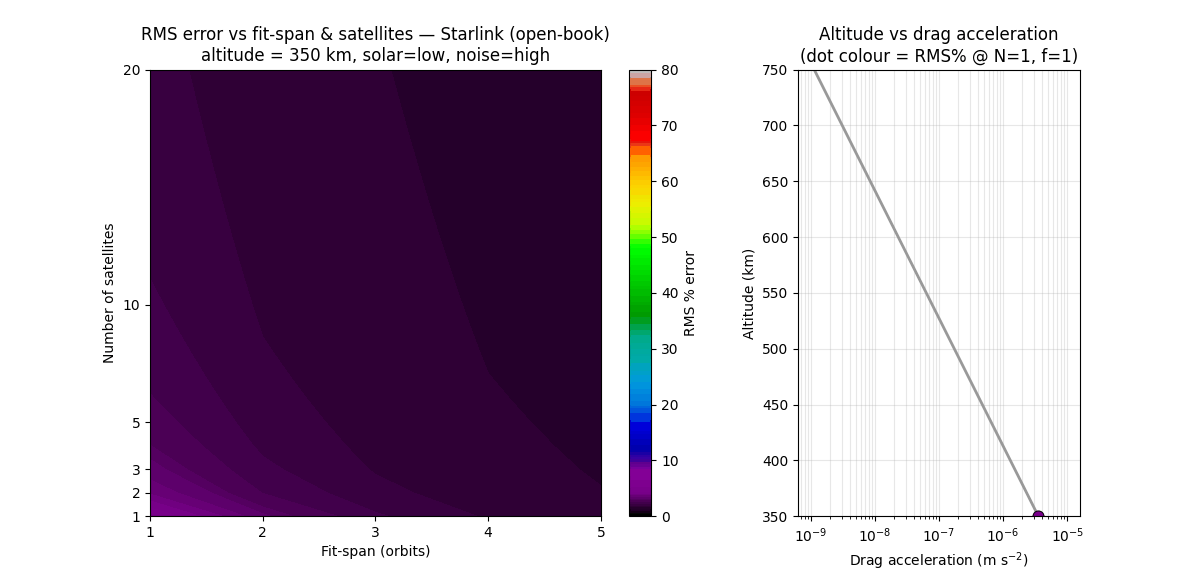

Saved animation to error_surface_vs_altitude_2panel_coloured_dot.gif


In [13]:
# Cell – 2-panel animation with dot coloured by 1-sat, f=1 RMS% error
# Left: error surface vs (fit-span, N). Right: altitude–drag with a moving dot
# whose colour encodes the RMS% error for N=1, f=1 at the current altitude.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib.colors import Normalize
from IPython.display import Image, display

# --- Scenario ---
case_sel   = 'Starlink (open-book)'   # 'Starlink (shark-fin)' or 'Spire'
# case_sel   = 'Spire'   # 'Starlink (shark-fin)' or 'Spire'
solar_sel  = 'low'                    # 'low' / 'medium' / 'high'
noise_sel  = 'high'                   # POD noise tier
alpha_sel, beta_sel = tier_calib[noise_sel]

# AMR for the chosen case (fallback if not found in req5_df)
amr_lookup = {'Starlink (open-book)': 0.005, 'Starlink (shark-fin)': 0.05, 'Spire': 0.02}
try:
    amr_sel = req5_df.loc[req5_df['case'] == case_sel, 'AMR_m2_per_kg'].iloc[0]
except Exception:
    amr_sel = amr_lookup[case_sel]

# Altitude sweep and grids
alts_km = np.arange(350, 751, 5)    # 350→850 km in 25-km steps
f_vals  = np.arange(1, 6)            # fit-spans 1–5
N_vals  = np.arange(1, 21)           # satellites 1–20
F_grid, N_grid = np.meshgrid(f_vals, N_vals)

# Precompute drag acceleration for the whole sweep (right-hand plot baseline)
def drag_at_alt(alt_km):
    rho = get_density_kg_m3(alt_km, solar_sel)
    v   = orbital_speed(alt_km)
    return drag_accel(rho, amr_sel, v)

drag_vals = np.array([drag_at_alt(a) for a in alts_km])
dmin, dmax = drag_vals.min(), drag_vals.max()
d_lo = 10**(np.floor(np.log10(dmin)) - 0.2)
d_hi = 10**(np.ceil(np.log10(dmax)) + 0.2)

# Colour mapping and contour lines (fixed across frames)
max_display  = 80.0
levels_fill  = np.linspace(0.0, max_display, 500)   # smooth gradient
levels_lines = [5.0, 10.0, 20.0]
norm = Normalize(vmin=0.0, vmax=max_display)
cmap = plt.cm.nipy_spectral
# cmap = plt.cm.gist_ncar

def compute_E_grid(alt_km):
    rho = get_density_kg_m3(alt_km, solar_sel)
    v   = orbital_speed(alt_km)
    d   = drag_accel(rho, amr_sel, v)
    return calibrated_error_surface(d, F_grid, N_grid, B_UNASSIM, alpha_sel, beta_sel)

def E_single_sat_f1(alt_km):
    """RMS% error at this altitude for N=1, f=1 (unassimilated)."""
    rho = get_density_kg_m3(alt_km, solar_sel)
    v   = orbital_speed(alt_km)
    d   = drag_accel(rho, amr_sel, v)
    return float(calibrated_error_surface(d, 1, 1, B_UNASSIM, alpha_sel, beta_sel))

# Figure with two subplots (left: error surface; right: altitude–drag)
fig, (axL, axR) = plt.subplots(
    1, 2, figsize=(12, 5.8),
    gridspec_kw={'width_ratios':[2.2, 1.1]}
)

# Static colorbar bound to a ScalarMappable
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap); sm.set_array([])
cbar = fig.colorbar(sm, ax=axL, ticks=np.arange(0, max_display+1, 10))
cbar.set_label('RMS % error')

def style_left_axes():
    axL.set_xlabel('Fit-span (orbits)')
    axL.set_ylabel('Number of satellites')
    axL.set_xticks(f_vals)
    # axL.set_yscale('log')
    axL.set_yticks([1, 2, 3, 5, 10, 20])
    axL.set_yticklabels(['1', '2', '3', '5', '10', '20'])

def style_right_axes():
    axR.set_xscale('log')
    axR.set_xlim(d_lo, d_hi)
    axR.set_ylim(alts_km.min(), alts_km.max())
    axR.set_xlabel('Drag acceleration (m s$^{-2}$)')
    axR.set_ylabel('Altitude (km)')
    axR.grid(True, which='both', alpha=0.3)

# Init: draw first frame for both panels
def init():
    axL.clear(); axR.clear()

    # Left panel: error surface at first altitude
    E0 = compute_E_grid(alts_km[0])
    axL.contourf(F_grid, N_grid, E0, levels=levels_fill, norm=norm, cmap=cmap, extend='max')
    linesL = axL.contour(F_grid, N_grid, E0, levels=levels_lines, colors='white', linewidths=2)
    axL.clabel(linesL, fmt={lv: f'{int(lv)}%' for lv in levels_lines}, inline=True, fontsize=9)
    style_left_axes()
    axL.set_title(f'RMS error vs fit-span & satellites — {case_sel}\n'
                  f'altitude = {int(alts_km[0])} km, solar={solar_sel}, noise={noise_sel}')

    # Right panel: full altitude–drag curve + coloured dot for N=1, f=1 error
    axR.semilogx(drag_vals, alts_km, color='0.6', lw=2)
    e1 = np.clip(E_single_sat_f1(alts_km[0]), 0.0, max_display)
    dot_color = cmap(norm(e1))
    axR.semilogx([drag_vals[0]], [alts_km[0]], 'o',
                 markerfacecolor=dot_color, markeredgecolor='k',
                 markersize=8, markeredgewidth=0.7)
    style_right_axes()
    axR.set_title('Altitude vs drag acceleration\n(dot colour = RMS% @ N=1, f=1)')
    return []

# Update: clear and redraw both panels for altitude index i
def update(i):
    axL.clear(); axR.clear()
    alt = alts_km[i]

    # Left panel
    E = compute_E_grid(alt)
    axL.contourf(F_grid, N_grid, E, levels=levels_fill, norm=norm, cmap=cmap, extend='max')
    linesL = axL.contour(F_grid, N_grid, E, levels=levels_lines, colors='white', linewidths=2)
    axL.clabel(linesL, fmt={lv: f'{int(lv)}%' for lv in levels_lines}, inline=True, fontsize=9)
    style_left_axes()
    axL.set_title(f'RMS error vs fit-span & satellites — {case_sel}\n'
                  f'altitude = {int(alt)} km, solar={solar_sel}, noise={noise_sel}')

    # Right panel
    axR.semilogx(drag_vals, alts_km, color='0.6', lw=2)
    e1 = np.clip(E_single_sat_f1(alt), 0.0, max_display)
    dot_color = cmap(norm(e1))
    axR.semilogx([drag_vals[i]], [alt], 'o',
                 markerfacecolor=dot_color, markeredgecolor='k',
                 markersize=8, markeredgewidth=0.7)
    style_right_axes()
    axR.set_title('Altitude vs drag acceleration\n(dot colour = RMS% @ N=1, f=1)')
    return []

anim = FuncAnimation(
    fig, update, frames=np.arange(len(alts_km)), init_func=init,
    interval=400, blit=False, save_count=len(alts_km)
)

gif_path = 'error_surface_vs_altitude_2panel_coloured_dot.gif'
anim.save(gif_path, writer=PillowWriter(fps=6))
plt.close(fig)

display(Image(filename=gif_path))
print(f"Saved animation to {gif_path}")